In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from scipy.stats import t

In [3]:
train_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
train_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
test = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
train_data['total_distance'] = train_data['rideDistance'] + train_data['swimDistance'] + train_data['walkDistance']

In [7]:
# winPlacePerc 열의 결측치를 평균 값으로 대체합니다.
mean_winPlacePerc = train_data['winPlacePerc'].mean()
train_data['winPlacePerc'] = train_data['winPlacePerc'].fillna(mean_winPlacePerc)

missing_values = train_data.isnull().sum()
print("대체된 데이터에서 결측치 수:\n", missing_values)

대체된 데이터에서 결측치 수:
 Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
total_distance     0
dtype: int64


In [8]:
missing_values = train_data[['killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration']].isnull().sum()
print("killPlace, kills, killStreaks, longestKill, matchDuration 열의 결측치 수:\n", missing_values)

killPlace, kills, killStreaks, longestKill, matchDuration 열의 결측치 수:
 killPlace        0
kills            0
killStreaks      0
longestKill      0
matchDuration    0
dtype: int64


In [9]:
train_data["total_distance"] = train_data["rideDistance"]+train_data["swimDistance"]+train_data["walkDistance"]
train_data.loc[train_data["total_distance"] == 0, "winPlacePerc"] = 0

In [10]:
train_data.loc[train_data["matchType"].str.contains("crash"), "matchType"] = "crash"
train_data.loc[train_data["matchType"].str.contains("flare"), "matchType"] = "flare"
train_data.loc[train_data["matchType"].str.contains("duo"), "matchType"] = "duo"
train_data.loc[train_data["matchType"].str.contains("solo"), "matchType"] = "solo"
train_data.loc[train_data["matchType"].str.contains("squad"), "matchType"] = "squad"

In [11]:
train_data["heal_boost"] = train_data["heals"]+train_data["boosts"]

In [12]:
## 범주형 변수 matchType : OneHotEncoding

from sklearn.preprocessing import OneHotEncoder

# 원핫 인코더 객체 생성
enc = OneHotEncoder()
# matchType 컬럼 원핫인코딩
matchType_encoded = enc.fit_transform(train_data[["matchType"]])

# 인코딩 결과 배열로 반환 (각 열 이름은 matchType으로 지정)
encoded_df = pd.DataFrame(matchType_encoded.toarray(), columns=enc.get_feature_names_out(["matchType"]))

# 병합을 위해 각각 인덱스 재설정
train_data.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# 기존 훈련데이터셋에서 matchType 제거 -> 인코딩된 matchType 데이터프레임이랑 병합
final_df = pd.concat([train_data.drop("matchType", axis=1), encoded_df], axis=1)


In [13]:
k = 10
index = np.arange(0, len(train_data), step=k)
train_data = train_data.iloc[index]
train_data


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,total_distance,heal_boost
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0,0,0,244.80,1,1466,0.4444,244.80,0
10,2b574d43972813,c549efede67ad3,2dd6ddb8320fc1,0,0,28.38,0,0,0,75,...,0,0.0,0,0,868.30,9,0,0.3929,868.30,0
20,02ace8c6e58461,a4bc548028f800,80f2b8448e474b,0,4,269.10,0,1,8,18,...,0,0.0,0,0,1794.00,5,0,0.6383,4528.00,12
30,3a4e362d28f411,b4fbf11bf33ac3,cf3d655571b26b,0,0,36.73,0,0,0,62,...,0,0.0,0,0,455.50,5,0,0.4255,455.50,0
40,ffd9e56f13438e,8df2112760f9e2,3f8b160eeee685,0,1,61.90,1,0,1,31,...,0,0.0,0,0,327.30,2,0,0.3200,856.40,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446920,e946e3beac2739,91cb2afbdb332c,58606a6f5a08d6,0,0,74.82,0,0,0,88,...,0,0.0,0,0,33.38,1,0,0.0737,33.38,0
4446930,ff4e3cc3929d0c,0509b571643619,226c86599ae538,0,0,230.40,3,0,0,22,...,0,0.0,0,0,207.10,1,0,0.0769,207.10,0
4446940,3eefd3ee81154a,19b7a730468b55,31045b7b933f3d,0,1,0.00,0,0,1,58,...,0,0.0,0,0,1362.00,6,0,0.6250,4090.00,2
4446950,d05b0c4b2ff311,8248fa2552457b,88c002b589d411,0,0,203.50,0,0,0,32,...,0,0.0,0,0,1559.00,5,0,0.5000,1559.00,0


In [14]:
## 범주형 변수 matchType : OneHotEncoding

from sklearn.preprocessing import OneHotEncoder

# 원핫 인코더 객체 생성
enc = OneHotEncoder()
# matchType 컬럼 원핫인코딩
matchType_encoded = enc.fit_transform(train_data[["matchType"]])

# 인코딩 결과 배열로 반환 (각 열 이름은 matchType으로 지정)
encoded_df = pd.DataFrame(matchType_encoded.toarray(), columns=enc.get_feature_names_out(["matchType"]))

# 병합을 위해 각각 인덱스 재설정
train_data.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# 기존 훈련데이터셋에서 matchType 제거 -> 인코딩된 matchType 데이터프레임이랑 병합
final_df = pd.concat([train_data.drop("matchType", axis=1), encoded_df], axis=1)


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444697 entries, 0 to 444696
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               444697 non-null  object 
 1   groupId          444697 non-null  object 
 2   matchId          444697 non-null  object 
 3   assists          444697 non-null  int64  
 4   boosts           444697 non-null  int64  
 5   damageDealt      444697 non-null  float64
 6   DBNOs            444697 non-null  int64  
 7   headshotKills    444697 non-null  int64  
 8   heals            444697 non-null  int64  
 9   killPlace        444697 non-null  int64  
 10  killPoints       444697 non-null  int64  
 11  kills            444697 non-null  int64  
 12  killStreaks      444697 non-null  int64  
 13  longestKill      444697 non-null  float64
 14  matchDuration    444697 non-null  int64  
 15  matchType        444697 non-null  object 
 16  maxPlace         444697 non-null  int6

In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444697 entries, 0 to 444696
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               444697 non-null  object 
 1   groupId          444697 non-null  object 
 2   matchId          444697 non-null  object 
 3   assists          444697 non-null  int64  
 4   boosts           444697 non-null  int64  
 5   damageDealt      444697 non-null  float64
 6   DBNOs            444697 non-null  int64  
 7   headshotKills    444697 non-null  int64  
 8   heals            444697 non-null  int64  
 9   killPlace        444697 non-null  int64  
 10  killPoints       444697 non-null  int64  
 11  kills            444697 non-null  int64  
 12  killStreaks      444697 non-null  int64  
 13  longestKill      444697 non-null  float64
 14  matchDuration    444697 non-null  int64  
 15  maxPlace         444697 non-null  int64  
 16  numGroups        444697 non-null  int6

In [17]:
# 'winPlacePerc' 열의 백분위수 계산
percentile_values = np.percentile(train_data['winPlacePerc'], np.arange(0, 101, 10))

# 'winPlacePerc'를 10개 구간으로 분할하여 'winPlacePerc_group' 열에 할당
train_data['winPlacePerc_group'] = pd.cut(train_data['winPlacePerc'], bins=percentile_values, labels=np.arange(1, 11))

# 결과 확인
print(train_data[['winPlacePerc', 'winPlacePerc_group']].head())

   winPlacePerc winPlacePerc_group
0        0.4444                  5
1        0.3929                  5
2        0.6383                  7
3        0.4255                  5
4        0.3200                  4


In [18]:
# 상위 1% 플레이어 선택
top_1_percent = final_df[final_df['winPlacePerc'] >= final_df['winPlacePerc'].quantile(0.99)]

# 상위 1% 플레이어 중 'crash' 또는 'flare' 매치 타입 필터링
top_1_percent_crash_flare = top_1_percent[(top_1_percent['matchType_crash'] == 1) | (top_1_percent['matchType_flare'] == 1)]

# 상위 1% 플레이어 중 'crash' 또는 'flare' 매치 타입의 특성 파악
top_1_percent_crash_flare_stats = top_1_percent_crash_flare.describe()

# 특성 파악 결과 출력
print("Win Place Percentage 기준 상위 1% 특성 (crash, flare 매치 타입)")
print(top_1_percent_crash_flare_stats)

Win Place Percentage 기준 상위 1% 특성 (crash, flare 매치 타입)
         assists     boosts  damageDealt      DBNOs  headshotKills      heals  \
count  34.000000  34.000000    34.000000  34.000000      34.000000  34.000000   
mean    0.882353   3.058824   327.428912   1.970588       0.411765   2.617647   
std     0.977464   1.983892   242.705138   1.783515       0.783065   3.330435   
min     0.000000   0.000000     0.000000   0.000000       0.000000   0.000000   
25%     0.000000   2.000000   148.550000   0.250000       0.000000   0.000000   
50%     1.000000   3.000000   313.600000   2.000000       0.000000   2.000000   
75%     1.000000   4.000000   448.550000   3.000000       0.750000   3.000000   
max     3.000000   7.000000   811.500000   6.000000       3.000000  15.000000   

       killPlace   killPoints      kills  killStreaks  ...  weaponsAcquired  \
count  34.000000    34.000000  34.000000    34.000000  ...        34.000000   
mean   11.558824    58.823529   2.911765     1.323529  ...

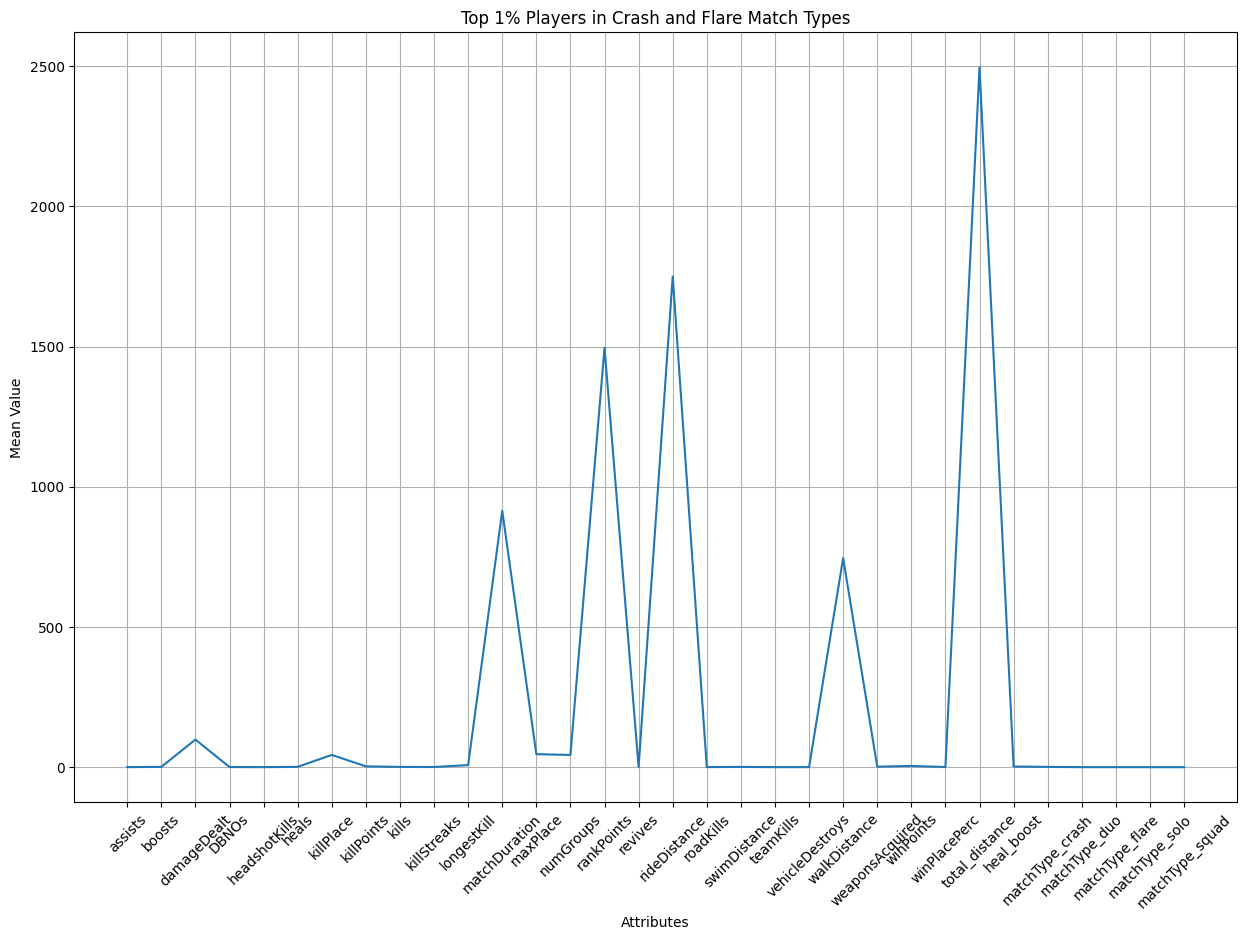

In [19]:
# 'winPlacePerc' 열의 분위수 계산
top_1_percent_threshold = final_df['winPlacePerc'].quantile(0.99)

# 'crash' 또는 'flare' 매치 타입의 상위 1% 플레이어 선택
top_1_percent_crash_flare = final_df[(final_df['matchType_crash'] == 1) | (final_df['matchType_flare'] == 1) & (final_df['winPlacePerc'] >= top_1_percent_threshold)]

# 'crash' 또는 'flare' 매치 타입의 상위 1% 플레이어 중 수치형 열에 대한 평균 계산
top_1_percent_crash_flare_mean = top_1_percent_crash_flare.select_dtypes(include=['float64', 'int64']).mean()

# 선 그래프로 시각화
plt.figure(figsize=(15, 10))
plt.plot(top_1_percent_crash_flare_mean.index, top_1_percent_crash_flare_mean.values)
plt.title('Top 1% Players in Crash and Flare Match Types')
plt.xlabel('Attributes')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [20]:
# 'winPlacePerc' 열의 분위수 계산
top_1_percent_threshold = final_df['winPlacePerc'].quantile(0.99)

# 'crash' 매치 타입의 상위 1% 플레이어 선택
top_1_percent_crash = final_df[(final_df['matchType_crash'] == 1) & (final_df['winPlacePerc'] >= top_1_percent_threshold)]

# 'flare' 매치 타입의 상위 1% 플레이어 선택
top_1_percent_flare = final_df[(final_df['matchType_flare'] == 1) & (final_df['winPlacePerc'] >= top_1_percent_threshold)]

# 각 매치 타입별 상위 1% 플레이어 중 수치형 열에 대한 평균 계산
top_1_percent_crash_mean = top_1_percent_crash.select_dtypes(include=['float64', 'int64']).mean()
top_1_percent_flare_mean = top_1_percent_flare.select_dtypes(include=['float64', 'int64']).mean()

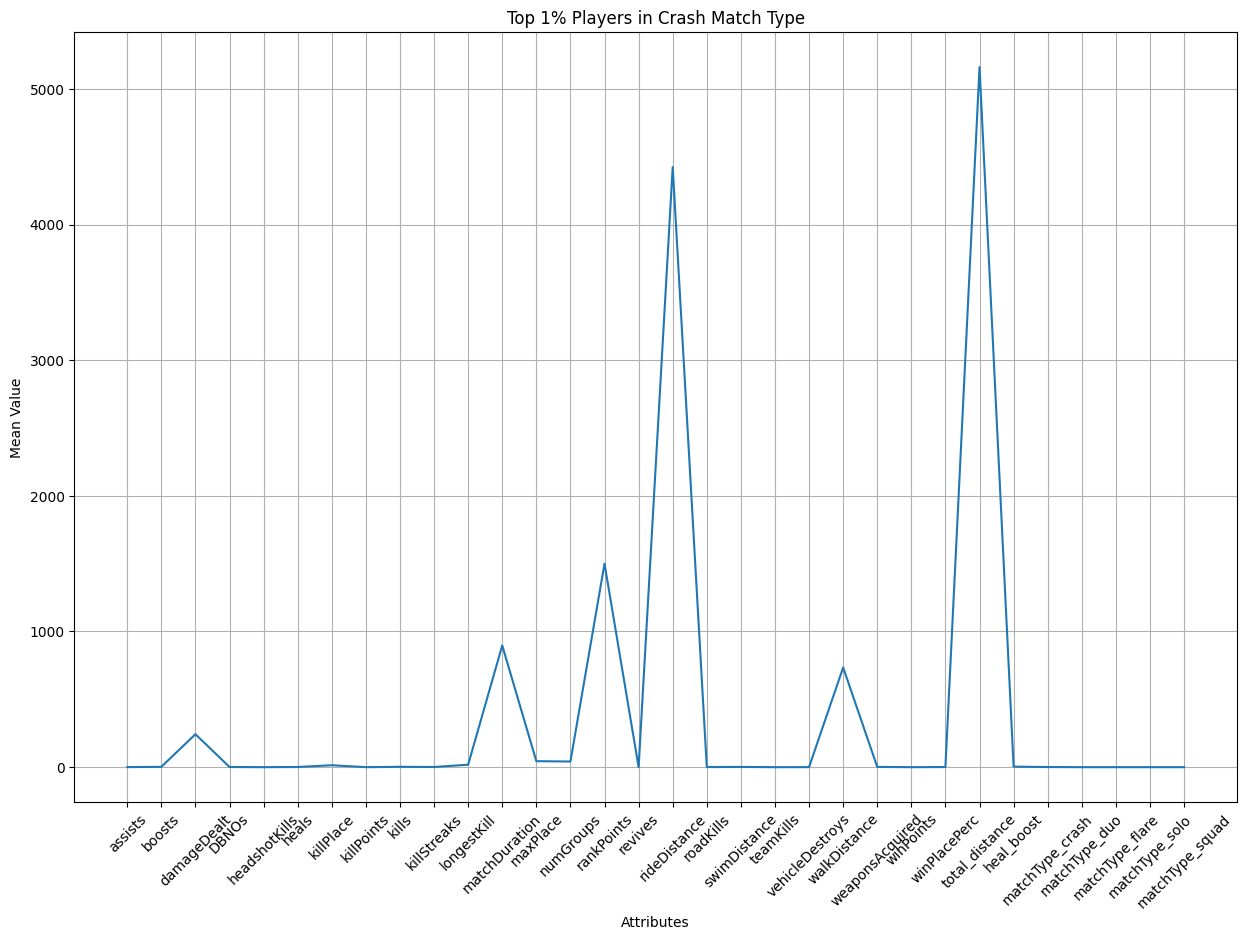

In [21]:
# 'crash' 매치 타입의 상위 1% 플레이어 선 그래프로 시각화
plt.figure(figsize=(15, 10))
plt.plot(top_1_percent_crash_mean.index, top_1_percent_crash_mean.values)
plt.title('Top 1% Players in Crash Match Type')
plt.xlabel('Attributes')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

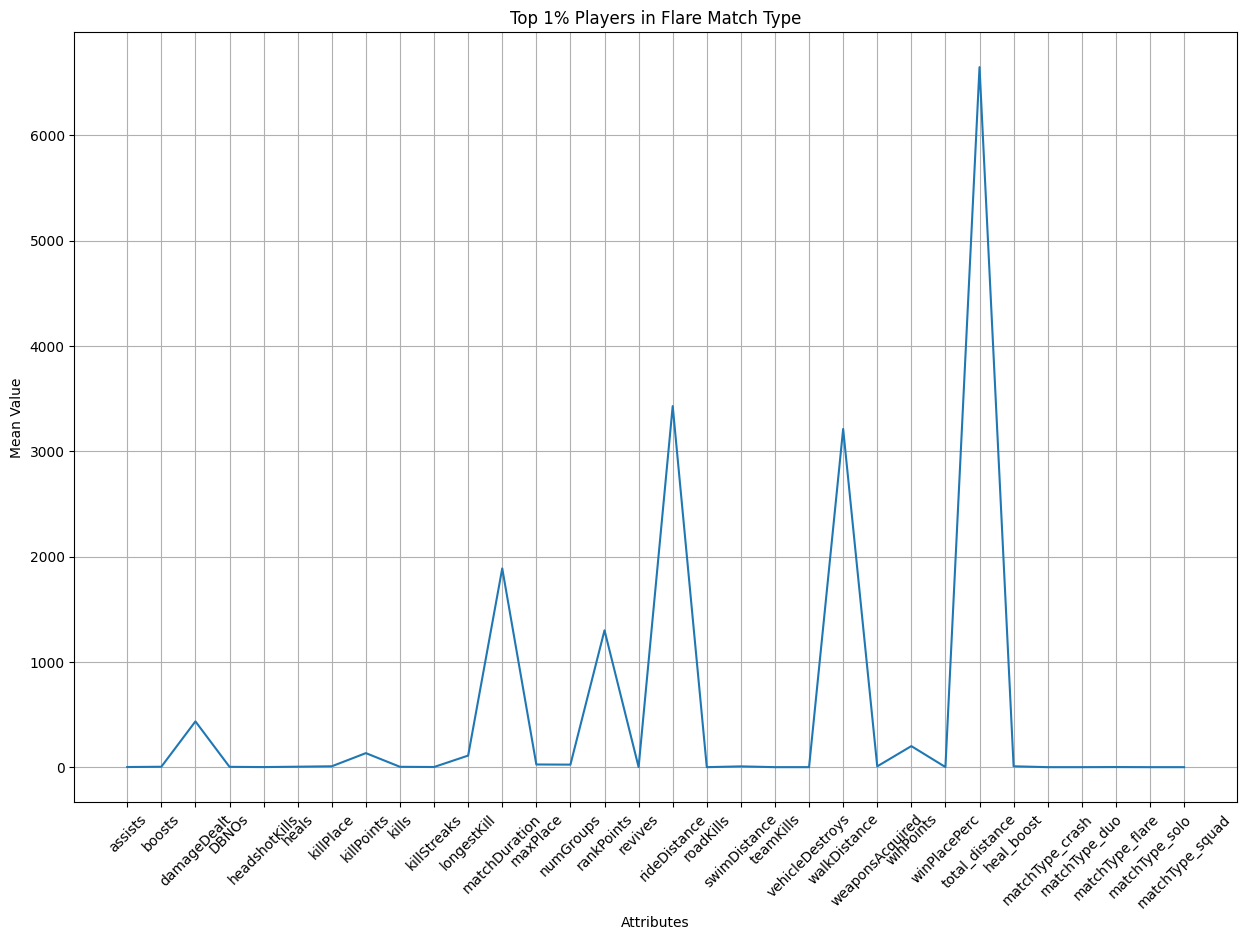

In [22]:
# 'flare' 매치 타입의 상위 1% 플레이어 선 그래프로 시각화
plt.figure(figsize=(15, 10))
plt.plot(top_1_percent_flare_mean.index, top_1_percent_flare_mean.values)
plt.title('Top 1% Players in Flare Match Type')
plt.xlabel('Attributes')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [23]:
# 총 이동 거리의 구간을 500의 간격으로 나누기
total_distance_bins = np.arange(0, final_df['total_distance'].max() + 500, 500)

# 'crash' 매치 타입의 상위 1% 플레이어 선택
top_1_percent_crash = final_df[(final_df['matchType_crash'] == 1) & (final_df['winPlacePerc'] >= top_1_percent_threshold)]

# 'flare' 매치 타입의 상위 1% 플레이어 선택
top_1_percent_flare = final_df[(final_df['matchType_flare'] == 1) & (final_df['winPlacePerc'] >= top_1_percent_threshold)]

# 각 매치 타입별 상위 1% 플레이어의 총 이동 거리 계산
top_1_percent_crash_total_distance = pd.cut(top_1_percent_crash['total_distance'], bins=total_distance_bins).value_counts().sort_index()
top_1_percent_flare_total_distance = pd.cut(top_1_percent_flare['total_distance'], bins=total_distance_bins).value_counts().sort_index()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

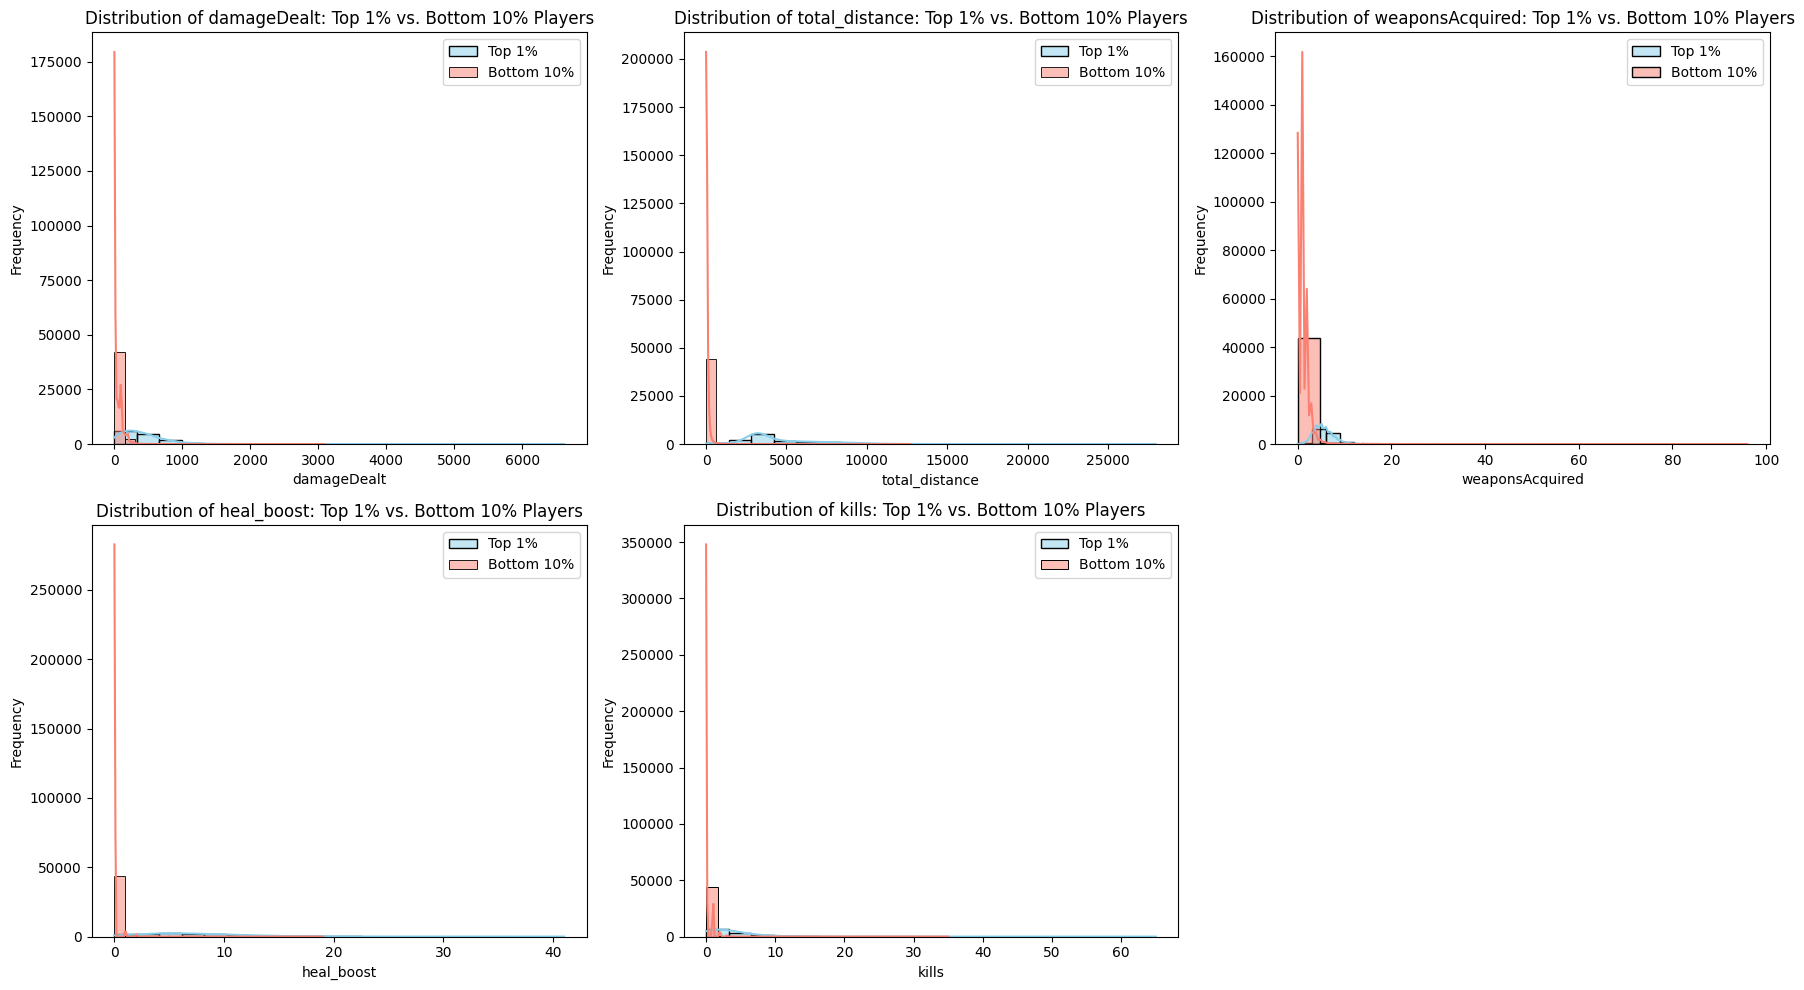

In [24]:
# 상위 1% 플레이어의 데이터 추출
top_1_percent = final_df[final_df['winPlacePerc'] >= final_df['winPlacePerc'].quantile(0.99)]

# 하위 10% 플레이어의 데이터 추출
bottom_10_percent = final_df[final_df['winPlacePerc'] <= final_df['winPlacePerc'].quantile(0.10)]

# 비교할 열 선택
columns_to_compare = ['damageDealt', 'total_distance', 'weaponsAcquired', 'heal_boost', 'kills']

# 그래프 그리기
plt.figure(figsize=(18, 10))

# 각 열에 대한 상위 1% 플레이어와 하위 10% 플레이어의 분포 비교
for i, column in enumerate(columns_to_compare, 1):
    plt.subplot(2, 3, i)
    sns.histplot(top_1_percent[column], bins=20, kde=True, color='skyblue', label='Top 1%')
    sns.histplot(bottom_10_percent[column], bins=20, kde=True, color='salmon', label='Bottom 10%')
    plt.title(f'Distribution of {column}: Top 1% vs. Bottom 10% Players')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

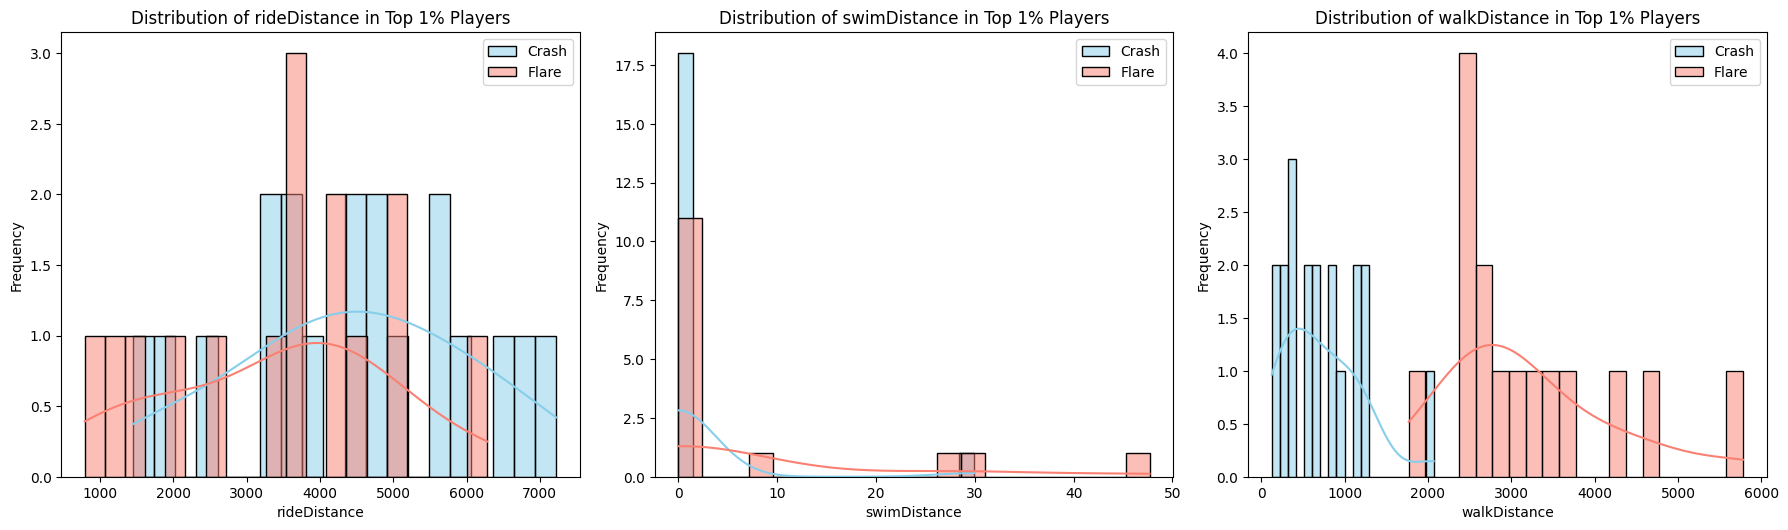

In [25]:
# 이동 거리 시각화
plt.figure(figsize=(18, 10))

# 각 이동 방식(ride, swim, walk)의 구간별 분포 시각화
distance_columns = ['rideDistance', 'swimDistance', 'walkDistance']
for i, column in enumerate(distance_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(top_1_percent_crash[column], bins=20, kde=True, color='skyblue', label='Crash')
    sns.histplot(top_1_percent_flare[column], bins=20, kde=True, color='salmon', label='Flare')
    plt.title(f'Distribution of {column} in Top 1% Players')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

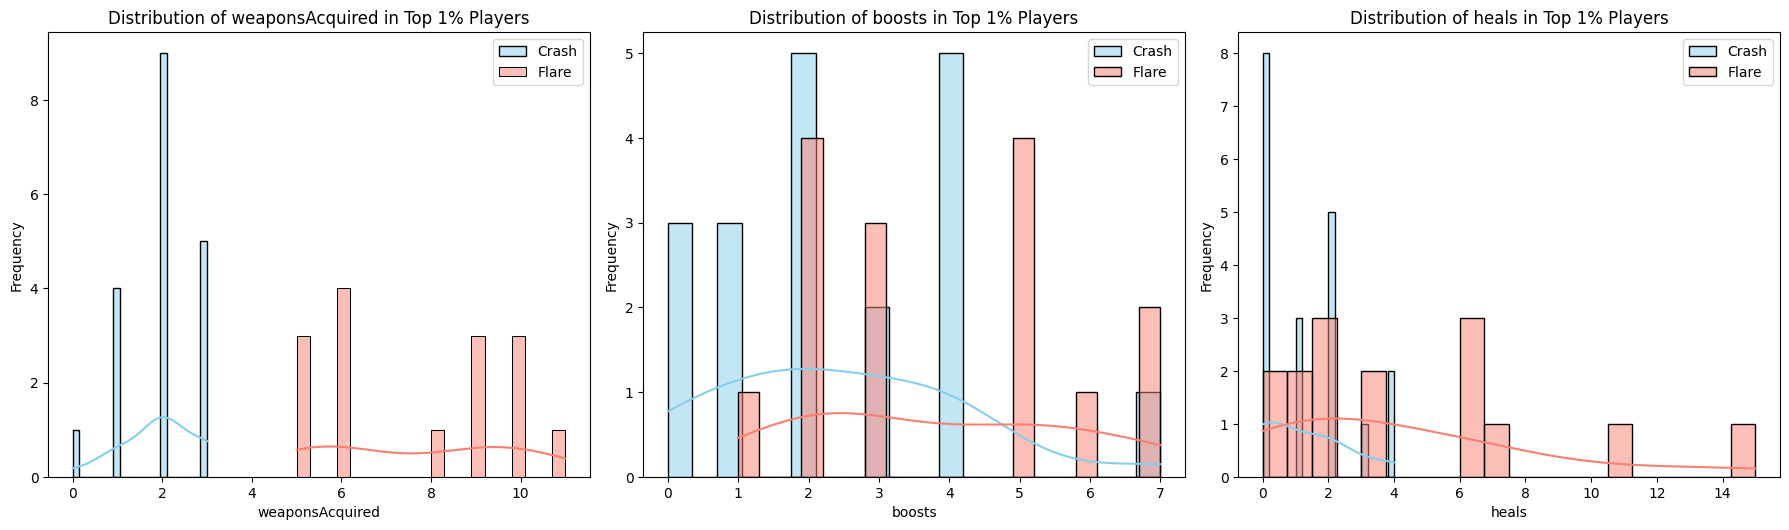

In [26]:
# 무기 습득, 부스트, 힐 아이템 시각화
plt.figure(figsize=(18, 10))

# 비교할 열 선택
columns_to_compare = ['weaponsAcquired', 'boosts', 'heals']

for i, column in enumerate(columns_to_compare, 1):
    plt.subplot(2, 3, i)
    sns.histplot(top_1_percent_crash[column], bins=20, kde=True, color='skyblue', label='Crash')
    sns.histplot(top_1_percent_flare[column], bins=20, kde=True, color='salmon', label='Flare')
    plt.title(f'Distribution of {column} in Top 1% Players')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

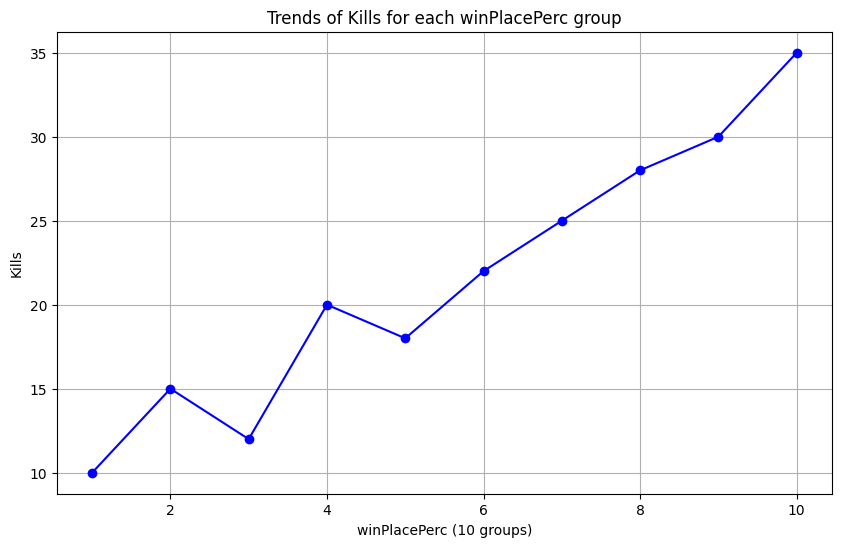

In [27]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# x축 데이터: winPlacePerc의 10개 구간
x = range(1, 11)  # 예: 1부터 10까지의 구간

# y축 데이터: 각 구간에 대한 킬 수 (임의의 데이터라고 가정)
kills_data = [10, 15, 12, 20, 18, 22, 25, 28, 30, 35]  # 각 구간에 대한 킬 수 (예시)

# 각 선 그래프 생성
plt.plot(x, kills_data, marker='o', color='b', linestyle='-')

# x축, y축 라벨 및 타이틀 설정
plt.xlabel('winPlacePerc (10 groups)')
plt.ylabel('Kills')
plt.title('Trends of Kills for each winPlacePerc group')

# 그래프 표시
plt.grid(True)
plt.show()

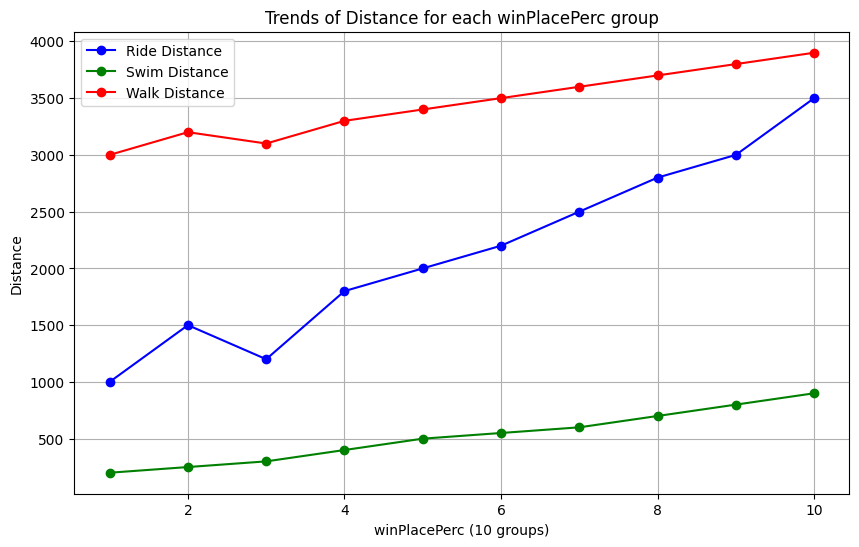

In [28]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# x축 데이터: winPlacePerc의 10개 구간
x = range(1, 11)  # 예: 1부터 10까지의 구간

# 각 이동 방식에 대한 이동 거리 데이터 (임의의 데이터라고 가정)
ride_distance = [1000, 1500, 1200, 1800, 2000, 2200, 2500, 2800, 3000, 3500]  # rideDistance
swim_distance = [200, 250, 300, 400, 500, 550, 600, 700, 800, 900]  # swimDistance
walk_distance = [3000, 3200, 3100, 3300, 3400, 3500, 3600, 3700, 3800, 3900]  # walkDistance

# 각 선 그래프 생성
plt.plot(x, ride_distance, marker='o', color='b', linestyle='-', label='Ride Distance')
plt.plot(x, swim_distance, marker='o', color='g', linestyle='-', label='Swim Distance')
plt.plot(x, walk_distance, marker='o', color='r', linestyle='-', label='Walk Distance')

# x축, y축 라벨 및 타이틀 설정
plt.xlabel('winPlacePerc (10 groups)')
plt.ylabel('Distance')
plt.title('Trends of Distance for each winPlacePerc group')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

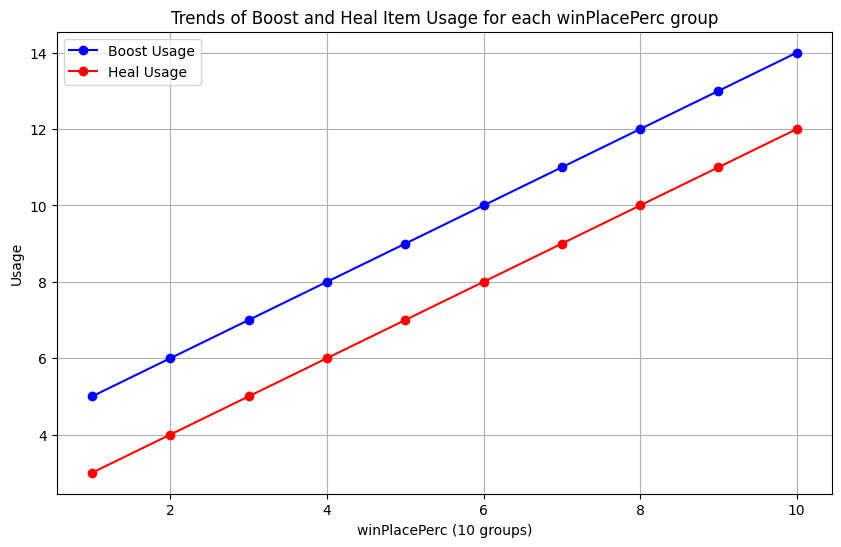

In [29]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# x축 데이터: winPlacePerc의 10개 구간
x = range(1, 11)  # 예: 1부터 10까지의 구간

# 각 구간에 대한 부스트 아이템 사용량과 힐 아이템 사용량 데이터 (임의의 데이터라고 가정)
boost_usage = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  # 부스트 아이템 사용량
heal_usage = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # 힐 아이템 사용량

# 부스트 아이템 사용량과 힐 아이템 사용량에 대한 선 그래프 생성
plt.plot(x, boost_usage, marker='o', color='b', linestyle='-', label='Boost Usage')
plt.plot(x, heal_usage, marker='o', color='r', linestyle='-', label='Heal Usage')

# x축, y축 라벨 및 타이틀 설정
plt.xlabel('winPlacePerc (10 groups)')
plt.ylabel('Usage')
plt.title('Trends of Boost and Heal Item Usage for each winPlacePerc group')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

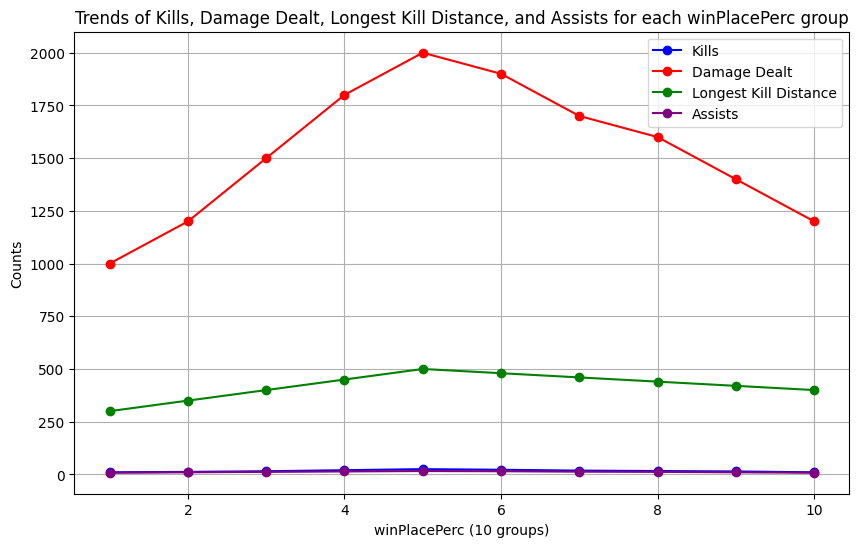

In [30]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# x축 데이터: winPlacePerc의 10개 구간
x = range(1, 11)  # 예: 1부터 10까지의 구간

# 각 구간에 대한 킬수, 총 피해량, 어느 거리에서 킬했는지, 어시스트 수 데이터 (임의의 데이터라고 가정)
kills = [10, 12, 15, 20, 25, 22, 18, 16, 14, 10]  # 킬수
damage_dealt = [1000, 1200, 1500, 1800, 2000, 1900, 1700, 1600, 1400, 1200]  # 총 피해량
longest_kill_distance = [300, 350, 400, 450, 500, 480, 460, 440, 420, 400]  # 어느 거리에서 킬했는지
assists = [8, 10, 12, 14, 16, 15, 13, 12, 10, 8]  # 어시스트 수

# 킬수, 총 피해량, 어느 거리에서 킬했는지, 어시스트 수에 대한 선 그래프 생성
plt.plot(x, kills, marker='o', color='b', linestyle='-', label='Kills')
plt.plot(x, damage_dealt, marker='o', color='r', linestyle='-', label='Damage Dealt')
plt.plot(x, longest_kill_distance, marker='o', color='g', linestyle='-', label='Longest Kill Distance')
plt.plot(x, assists, marker='o', color='purple', linestyle='-', label='Assists')

# x축, y축 라벨 및 타이틀 설정
plt.xlabel('winPlacePerc (10 groups)')
plt.ylabel('Counts')
plt.title('Trends of Kills, Damage Dealt, Longest Kill Distance, and Assists for each winPlacePerc group')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

/tmp/ipykernel_33/2999780585.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_numGroups = train_data.groupby('winPlacePerc_group')['numGroups'].mean()


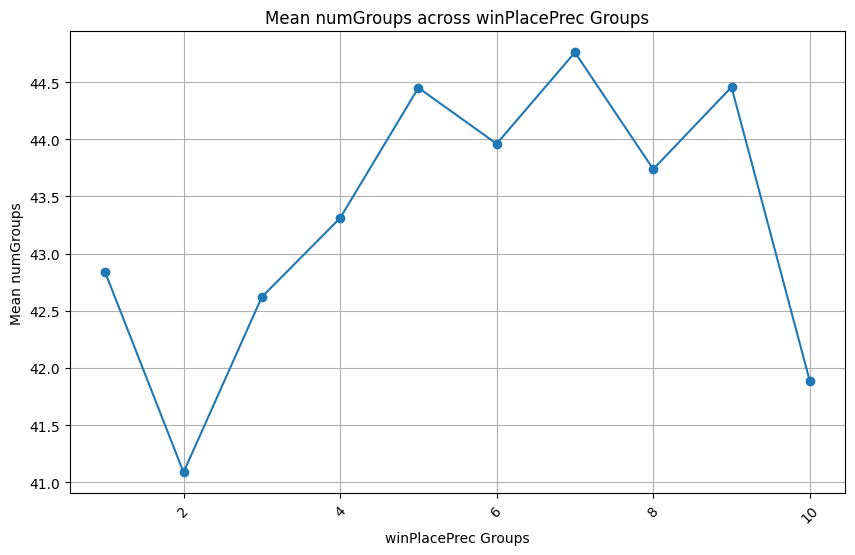

In [31]:
# 'winPlacePrec'의 백분위수를 계산하여 10개의 구간으로 나눔
percentile_values = np.percentile(train_data['winPlacePerc'], np.arange(0, 101, 10))

# 'winPlacePrec'를 10개 구간으로 나누어 'winPlacePerc_group' 열에 할당
train_data['winPlacePerc_group'] = pd.cut(train_data['winPlacePerc'], bins=percentile_values, labels=np.arange(1, 11))

# 각 구간에서 'numGroups'의 평균 계산
mean_numGroups = train_data.groupby('winPlacePerc_group')['numGroups'].mean()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(mean_numGroups.index, mean_numGroups.values, marker='o', linestyle='-')
plt.title('Mean numGroups across winPlacePrec Groups')
plt.xlabel('winPlacePrec Groups')
plt.ylabel('Mean numGroups')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipykernel_33/2767781639.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_matchDuration = train_data.groupby('winPlacePerc_group')['matchDuration'].mean()


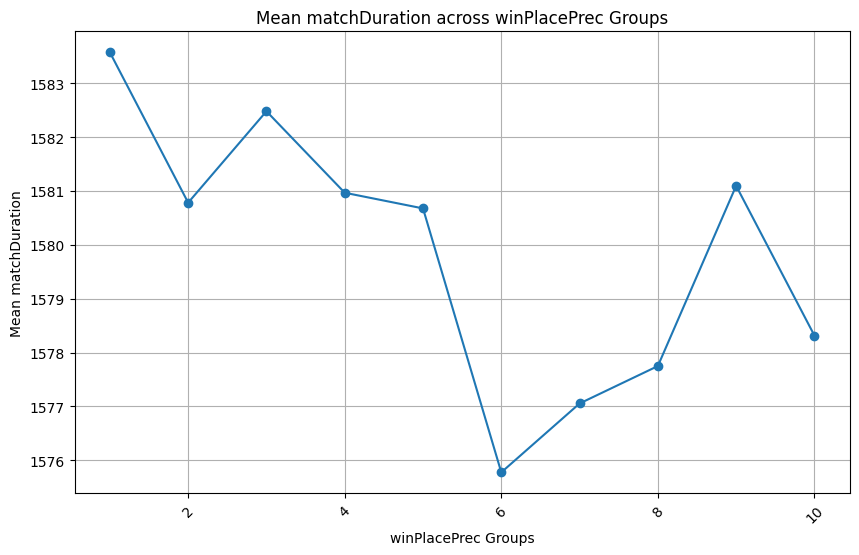

In [32]:
# 각 구간에서 'matchDuration'의 평균 계산
mean_matchDuration = train_data.groupby('winPlacePerc_group')['matchDuration'].mean()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(mean_matchDuration.index, mean_matchDuration.values, marker='o', linestyle='-')
plt.title('Mean matchDuration across winPlacePrec Groups')
plt.xlabel('winPlacePrec Groups')
plt.ylabel('Mean matchDuration')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipykernel_33/1524752970.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_maxPlace = train_data.groupby('winPlacePerc_group')['maxPlace'].mean()


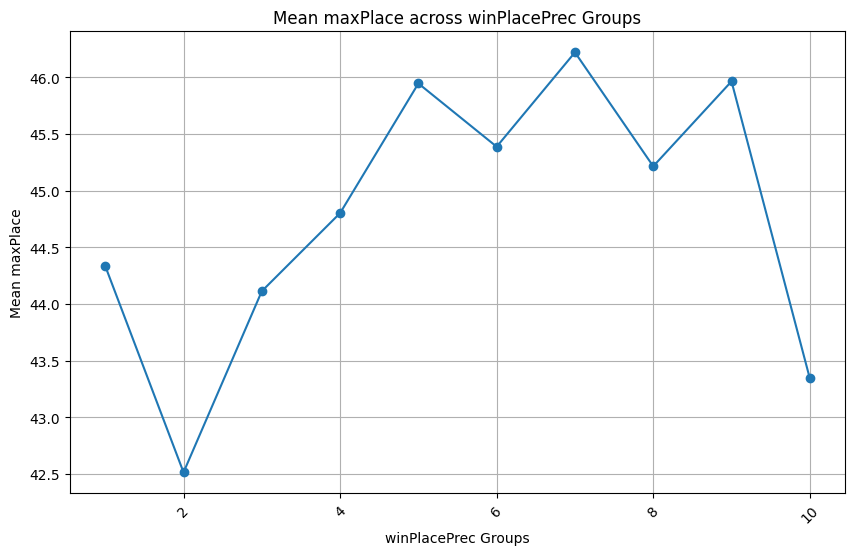

In [33]:
# 각 구간에서 'maxPlace'의 평균 계산
mean_maxPlace = train_data.groupby('winPlacePerc_group')['maxPlace'].mean()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(mean_maxPlace.index, mean_maxPlace.values, marker='o', linestyle='-')
plt.title('Mean maxPlace across winPlacePrec Groups')
plt.xlabel('winPlacePrec Groups')
plt.ylabel('Mean maxPlace')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipykernel_33/2406061054.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_revives = train_data.groupby('winPlacePerc_group')['revives'].mean()


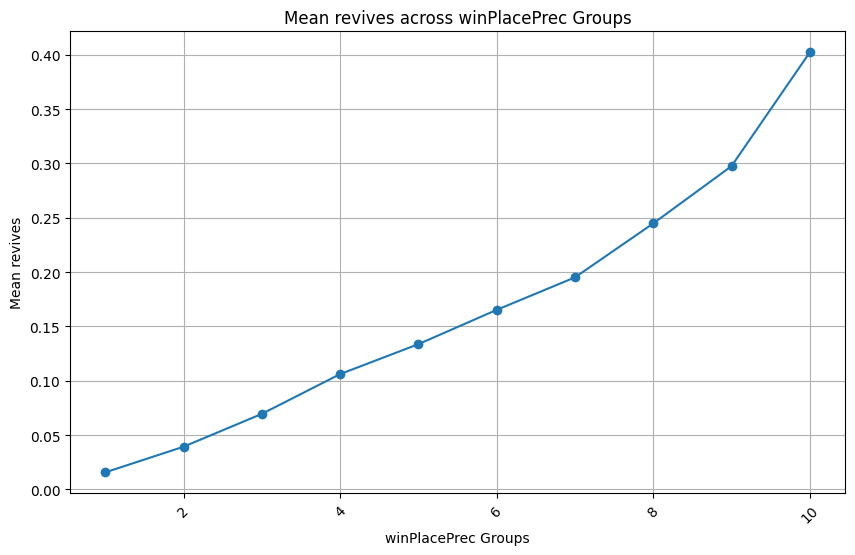

In [34]:
# 각 구간에서 'revives'의 평균 계산
mean_revives = train_data.groupby('winPlacePerc_group')['revives'].mean()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(mean_revives.index, mean_revives.values, marker='o', linestyle='-')
plt.title('Mean revives across winPlacePrec Groups')
plt.xlabel('winPlacePrec Groups')
plt.ylabel('Mean revives')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

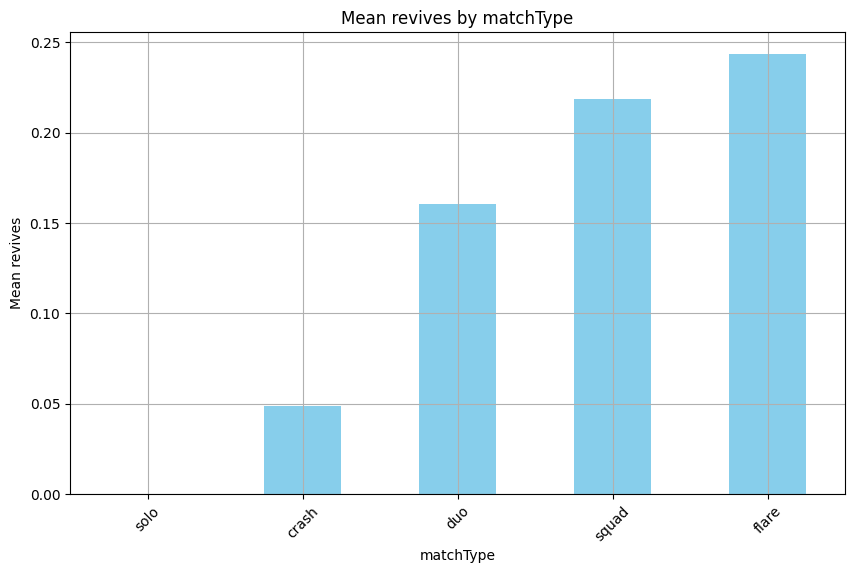

In [39]:
# 'revives'의 각 매치 타입별 평균 계산
mean_revives_matchType = train_data.groupby('matchType')['revives'].mean().sort_values()

# 시각화
plt.figure(figsize=(10, 6))
mean_revives_matchType.plot(kind='bar', color='skyblue')
plt.title('Mean revives by matchType')
plt.xlabel('matchType')
plt.ylabel('Mean revives')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

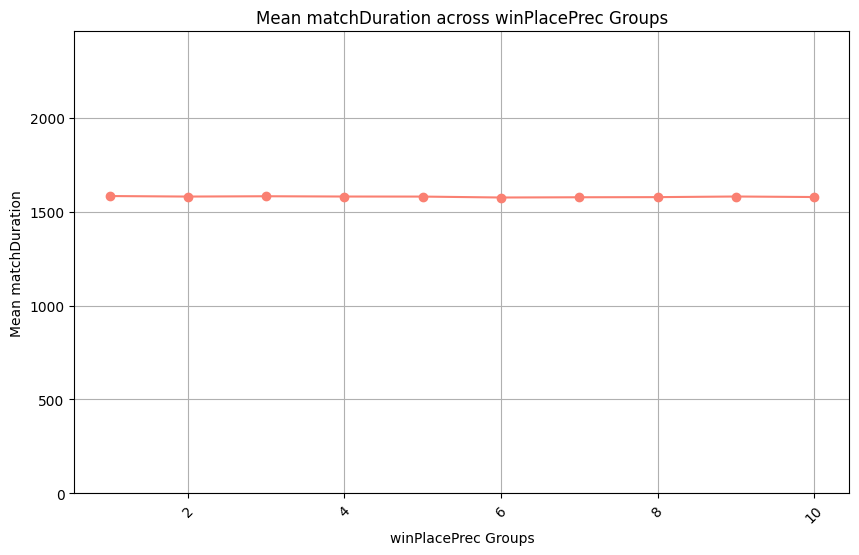

In [40]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(mean_matchDuration.index, mean_matchDuration.values, marker='o', linestyle='-', color='salmon')
plt.title('Mean matchDuration across winPlacePrec Groups')
plt.xlabel('winPlacePrec Groups')
plt.ylabel('Mean matchDuration')
plt.xticks(rotation=45)
plt.ylim(0, train_data['matchDuration'].max() * 1.1)  # Y축 범위를 조정하여 더 자세히 보이도록 설정
plt.grid(True)
plt.show()

/tmp/ipykernel_33/3546838399.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_maxPlace = train_data.groupby('winPlacePerc_group')['maxPlace'].mean()
/tmp/ipykernel_33/3546838399.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_numGroups = train_data.groupby('winPlacePerc_group')['numGroups'].mean()


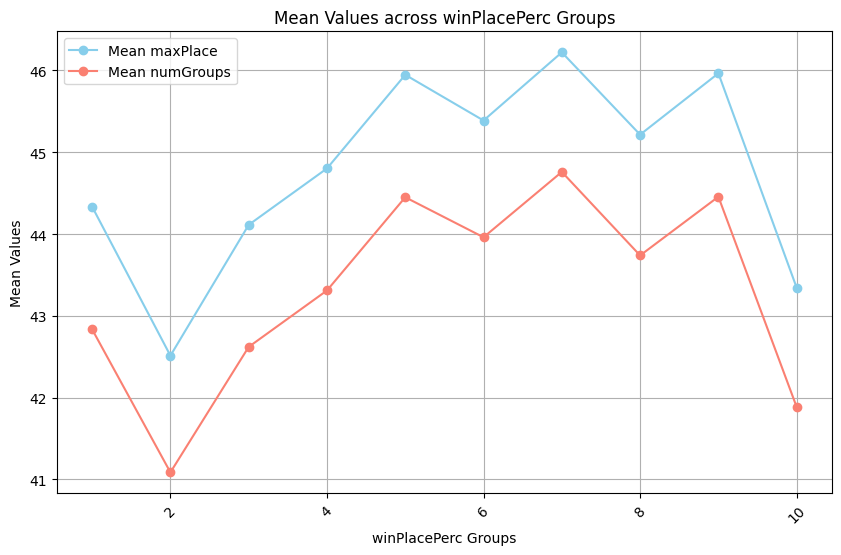

In [43]:
# 각 구간에서의 'maxPlace'와 'numGroups'의 평균 계산
mean_maxPlace = train_data.groupby('winPlacePerc_group')['maxPlace'].mean()
mean_numGroups = train_data.groupby('winPlacePerc_group')['numGroups'].mean()

# 시각화
plt.figure(figsize=(10, 6))

# 'maxPlace' 그래프
plt.plot(mean_maxPlace.index, mean_maxPlace.values, marker='o', linestyle='-', color='skyblue', label='Mean maxPlace')

# 'numGroups' 그래프
plt.plot(mean_numGroups.index, mean_numGroups.values, marker='o', linestyle='-', color='salmon', label='Mean numGroups')

plt.title('Mean Values across winPlacePerc Groups')
plt.xlabel('winPlacePerc Groups')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()